# Stabla odlučivanja

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix

## Problem klasifikacije

S obzirom da je skup podataka <i>Spam emails</i> namenjen upravo za detekciju da li pošta spada u neželjenu ili ne, probaćemo uz drveta odlučivanja da napravimo odgovarajući klasifikator.

### Učitavanje i preprocesiranje podataka

In [2]:
# TODO: Replace for loops with list comprehension

def parse_attributes(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
    except Exception as e:
        print(e)
    
    word_frequencies, chars_frequencies = [], []
    words, chars = [], []
    
    for line in lines[33 : 81]:
        word_frequencies.append(line[0 : line.index(':')])
        words.append(line[0 : line.index(':')][10:])
    
    for line in lines[81 : 87]:
        chars_frequencies.append(line[0 : line.index(':')])
        chars.append(line[0 : line.index(':')][10:])
    
    full_feature_names = word_frequencies + chars_frequencies
    feature_names = words + chars
    
    for line in lines[87 : ]:
        full_feature_names.append(line[0 : line.index(':')])
        feature_names.append(line[0 : line.index(':')])
        
    feature_names += ['class']
    full_feature_names += ['class']
    
    return full_feature_names, feature_names

In [3]:
_, feature_names = parse_attributes('../../dataset/spambase.names')
data = pd.read_csv('../../dataset/spambase.data', names= feature_names)

In [4]:
data.head()

,make,address,all,3d,our,over,remove,internet,order,mail,...,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
print(f'Skup podataka sadrži {data.shape[0]} instancu i {data.shape[1]} atributa.')

Skup podataka sadrži 4601 instancu i 58 atributa.


Osnovne statistike podataka:

In [6]:
data.describe()

,make,address,all,3d,our,over,remove,internet,order,mail,...,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


Kao što je već primećeno prilikom inicijalne analize podataka, u skupu nemamo nedostajućih vrednosti.

In [7]:
data.isna().sum()

make                          0
address                       0
all                           0
3d                            0
our                           0
over                          0
remove                        0
internet                      0
order                         0
mail                          0
receive                       0
will                          0
people                        0
report                        0
addresses                     0
free                          0
business                      0
email                         0
you                           0
credit                        0
your                          0
font                          0
000                           0
money                         0
hp                            0
hpl                           0
george                        0
650                           0
lab                           0
labs                          0
telnet                        0
857     

Pošto je u pitanju klasifikacioni problem, kao ciljnu promenljivu u ovom slučaju izdvajamo promenljivu <b><i>class</i></b>, dok ćemo neke od preostalih atributa koristiti za predviđanje. 

In [8]:
y = data[['class']]
y.head()

,class
0,1
1,1
2,1
3,1
4,1


Prediktori:

In [9]:
X = data.drop('class', axis= 1)
X.head()

,make,address,all,3d,our,over,remove,internet,order,mail,...,conference,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


Za atribute koji nisu ciljna promenljiva možemo prikazati matricu korelacije, kako bismo potencijalno taj skup redukovali.

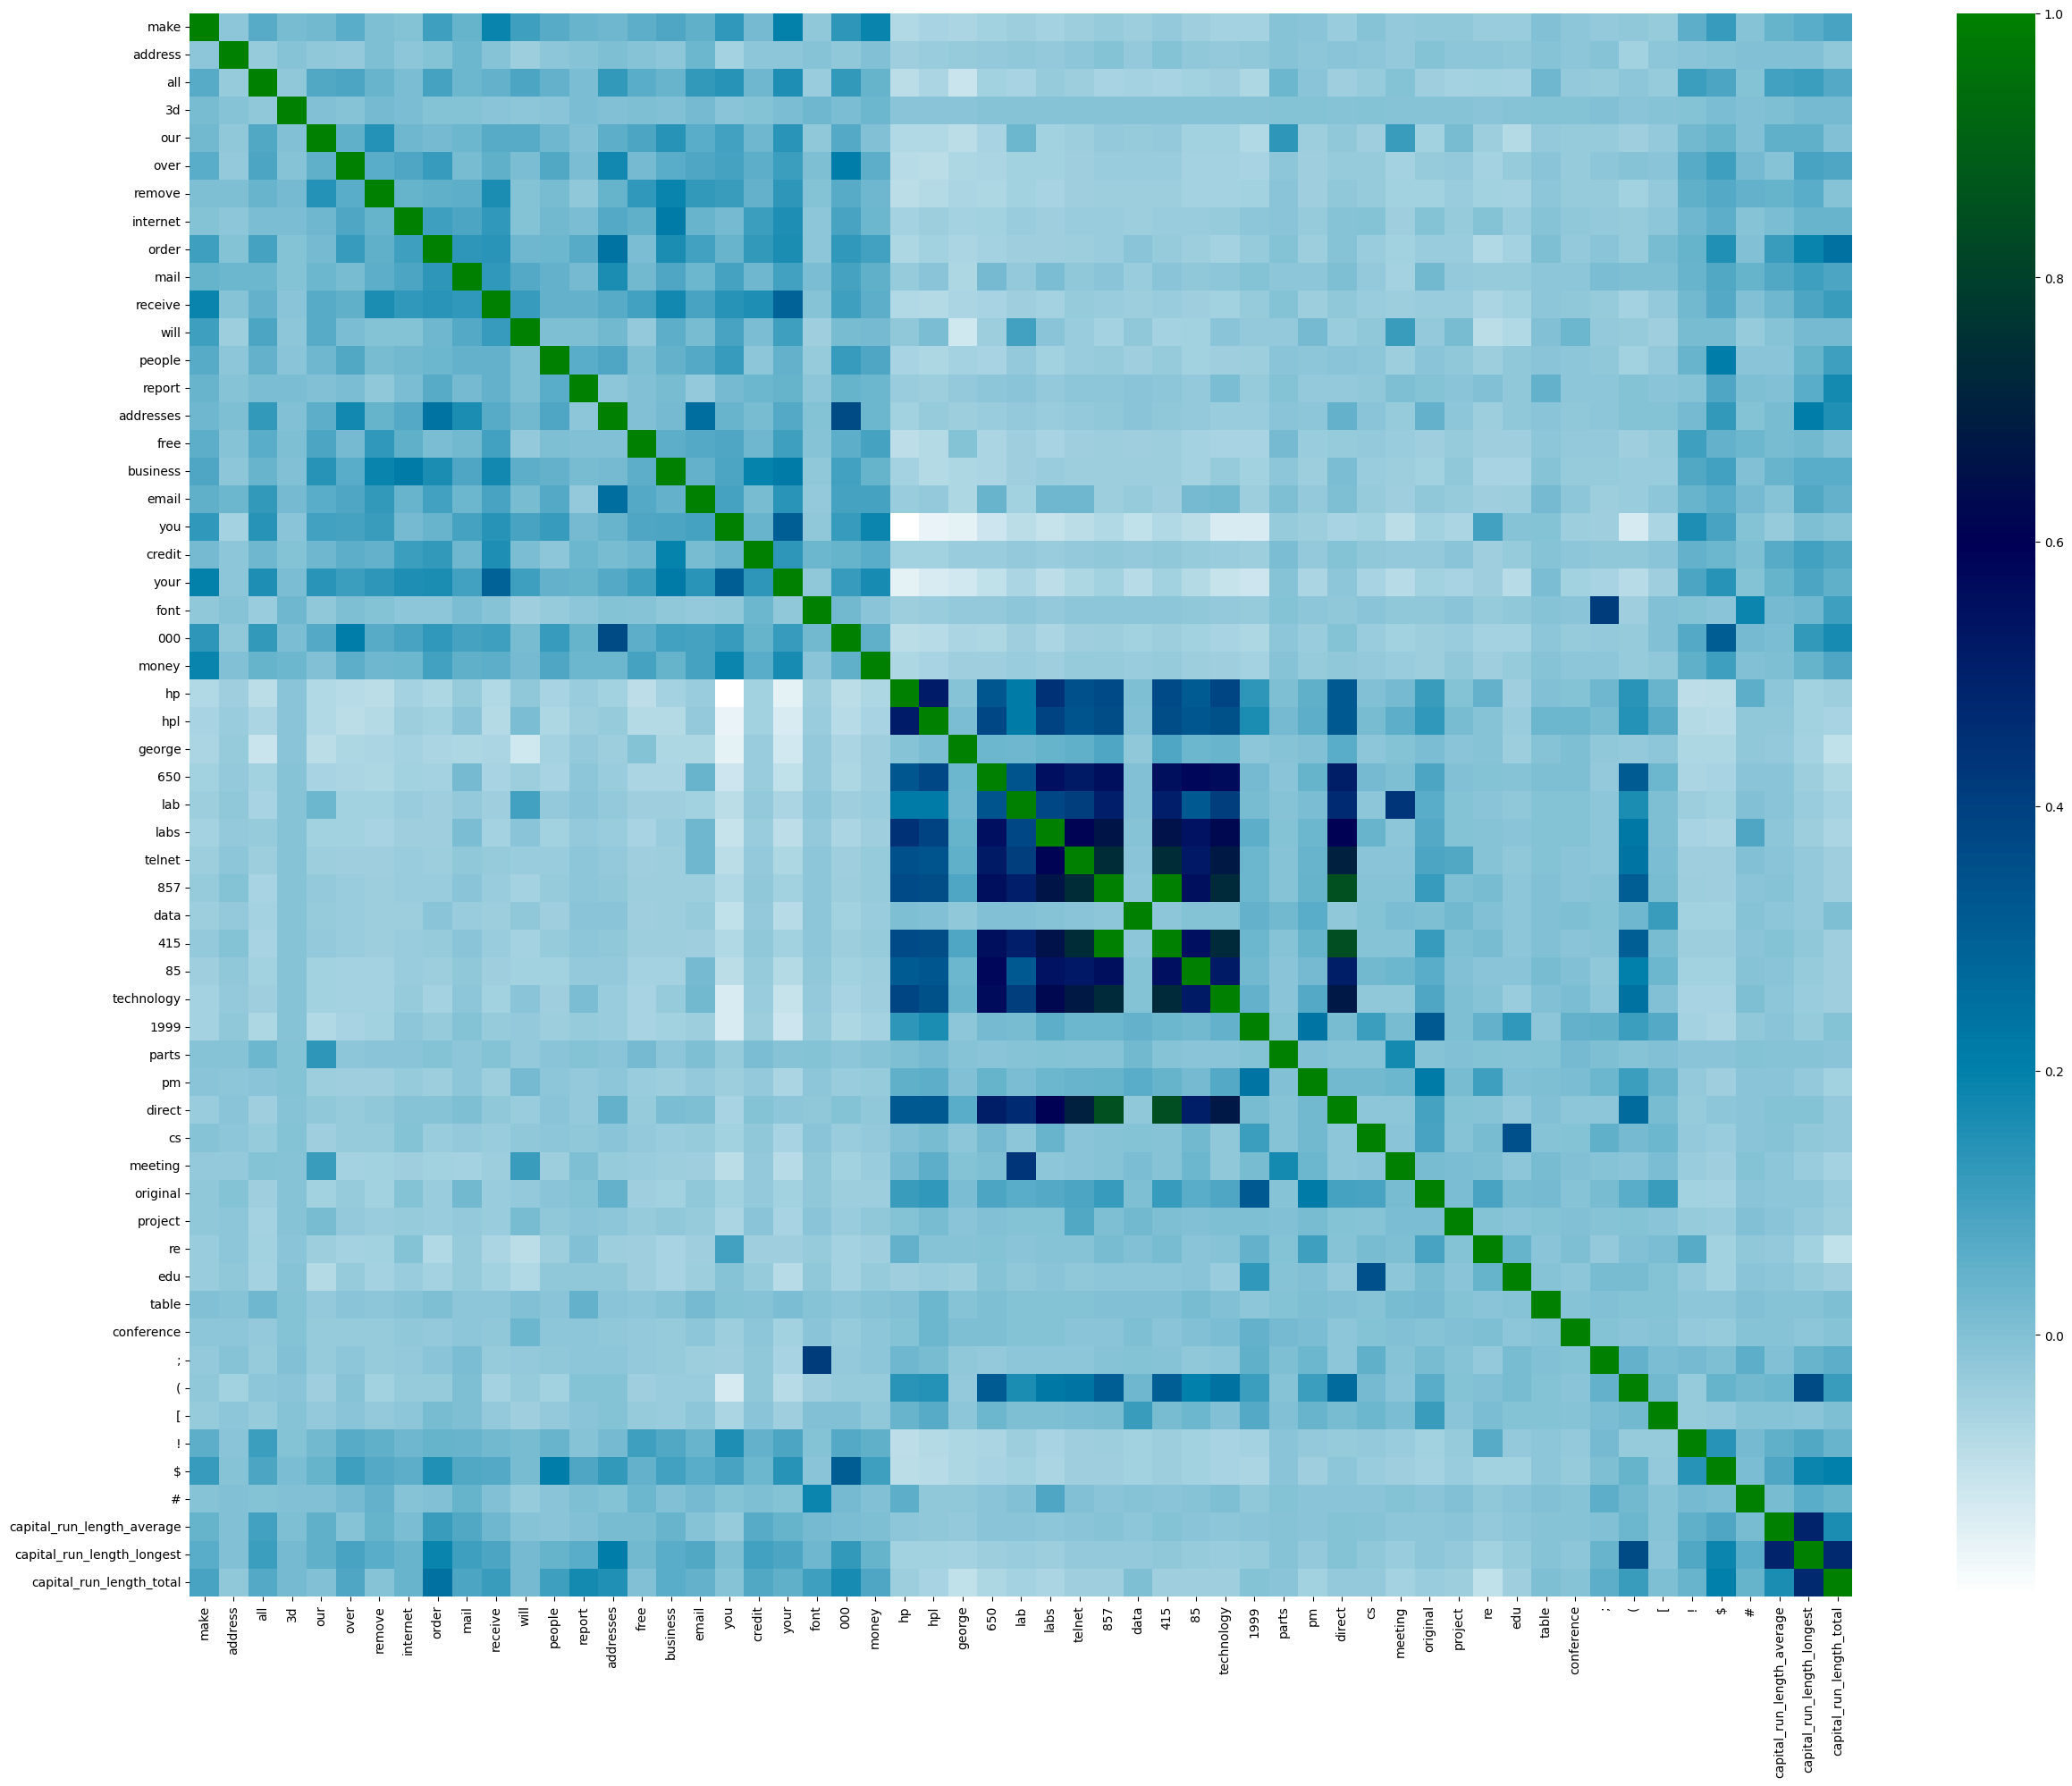

In [10]:
correlation_matrix = X.corr()

plt.figure(figsize = (30, 23))
_ = sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns.values, 
            yticklabels=correlation_matrix.columns.values, cmap= plt.cm.ocean_r)

> Možemo primetiti da atribut `415` i `857` imaju visok koeficijent korelacije. Sa tim u vidu, uklanjamo kolone sa datim atributima.

In [11]:
correlation_matrix['415']['857']

0.9960660509313944

In [12]:
X = X.drop(['415', '857'], axis= 1)
X.head()

,make,address,all,3d,our,over,remove,internet,order,mail,...,conference,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


U analizi podataka smo primetili da su naše klase nebalansirane.

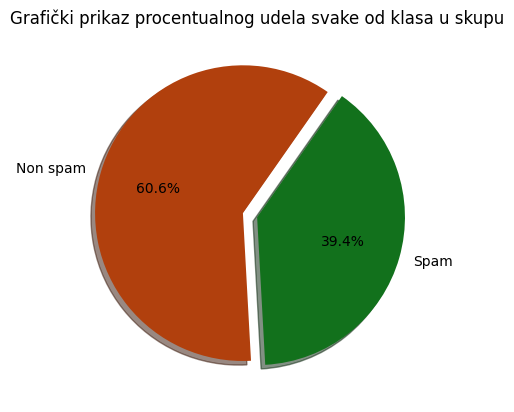

In [13]:
colors = sns.color_palette("dark")[1:3]

plt.pie(y.value_counts(), labels= ['Non spam', 'Spam'], colors= colors, startangle= 55, explode= (0.1, 0.0), 
        shadow= True, autopct= '%.1f%%')
plt.title('Grafički prikaz procentualnog udela svake od klasa u skupu')
plt.show()

> Međutim, za početni pokušaj nećemo vršiti balansiranje podataka.

### Podela podataka na trening i test skup

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, stratify= y, random_state= 42)

> Čisto eksperimentalno, uzeto je da veličina test skupa bude 30% od ukupnog broja podataka

In [15]:
X_train.shape

(3220, 55)

In [16]:
X_test.shape

(1381, 55)

Pošto znamo da kolone `capital_run_length_average`, `capital_run_length_longest`, `capital_run_length_total` obuhvataju znatno veći opseg vrednosti u odnosu na preostale, vršimo skaliranje podataka uz korišćenje `MinMaxScalera` na opseg od 0 do 100.

Podaci pre skaliranja:

In [17]:
X_train.iloc[:, 52:]

,capital_run_length_average,capital_run_length_longest,capital_run_length_total
132,2.360,19,144
1358,3.613,63,318
2569,1.421,8,91
2842,2.634,23,303
4536,1.687,4,27
...,...,...,...
1861,1.000,1,14
2366,1.300,4,13
266,5.687,39,91
277,16.217,147,373


In [18]:
scaler = MinMaxScaler(feature_range= (0, 100))
X_train[['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']] = scaler.fit_transform(X_train[['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']])

Podaci nakon skaliranja:

In [19]:
X_train.iloc[:, 52:]

,capital_run_length_average,capital_run_length_longest,capital_run_length_total
132,0.123468,0.180216,0.902778
1358,0.237222,0.620745,2.001263
2569,0.038221,0.070084,0.568182
2842,0.148343,0.220264,1.906566
4536,0.062369,0.030036,0.164141
...,...,...,...
1861,0.000000,0.000000,0.082071
2366,0.027236,0.030036,0.075758
266,0.425511,0.380457,0.568182
277,1.381480,1.461754,2.348485


### Kreiranje modela

Pomoću `DecisionTreeClassifier`a iz biblioteke `scikit-learn`, kreiramo model koji će predikcije vršiti po principu `CART` algoritma. Konkretno, ova biblioteka nema podršku za veći broj algoritama baziranim na drvetima odlučivanja, već podržava samo optimizovanu verziju CART algoritma.

In [20]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [21]:
# Kod sa časova za vizuelizaciju rezultata
# !pip install termcolor
from sklearn.metrics import classification_report
from termcolor import colored

def report(model, x, y, text = "trening"):
    y_pred = model.predict(x)
    
    print(colored(f'Klasifikacioni izveštaj za model {type(model).__name__} nad {text} podacima', 'blue'))
    print('------------------------------------------------------------------------------------')
    print(classification_report(y, y_pred))
    

def plot_confusion_matrix(model, x, y, text = 'training'):
    y_pred = model.predict(x)
    
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', ax=ax, cmap= plt.cm.ocean_r);
    
    ax.set_xlabel('Predviđene vrednosti')
    ax.set_ylabel('Stvarne vrednosti')
    
    ax.set_title('Matrica konfuzije') 
    ax.xaxis.set_ticklabels(['Spam', 'Non spam'])
    ax.yaxis.set_ticklabels(['Non spam', 'Spam'])

def plot_decision_tree(model, feature_names):
    plt.figure(figsize=(15, 10))
    plot_tree(model, class_names=['Spam', 'Non spam'], feature_names=feature_names, filled=True)
    plt.title(f'Drvo odlučivanja dubine {model.get_depth()} sa {model.get_n_leaves()} čvorova')

    plt.show()
    print("---------------------------------------------------------------------------------")
    print(colored(f'Parametri modela {type(model).__name__}', 'blue'))
    for k, v in model.get_params().items():
        print(colored(k, 'red'), v)
    
    print("---------------------------------------------------------------------------------")

### Analiza dobijenih rezultata

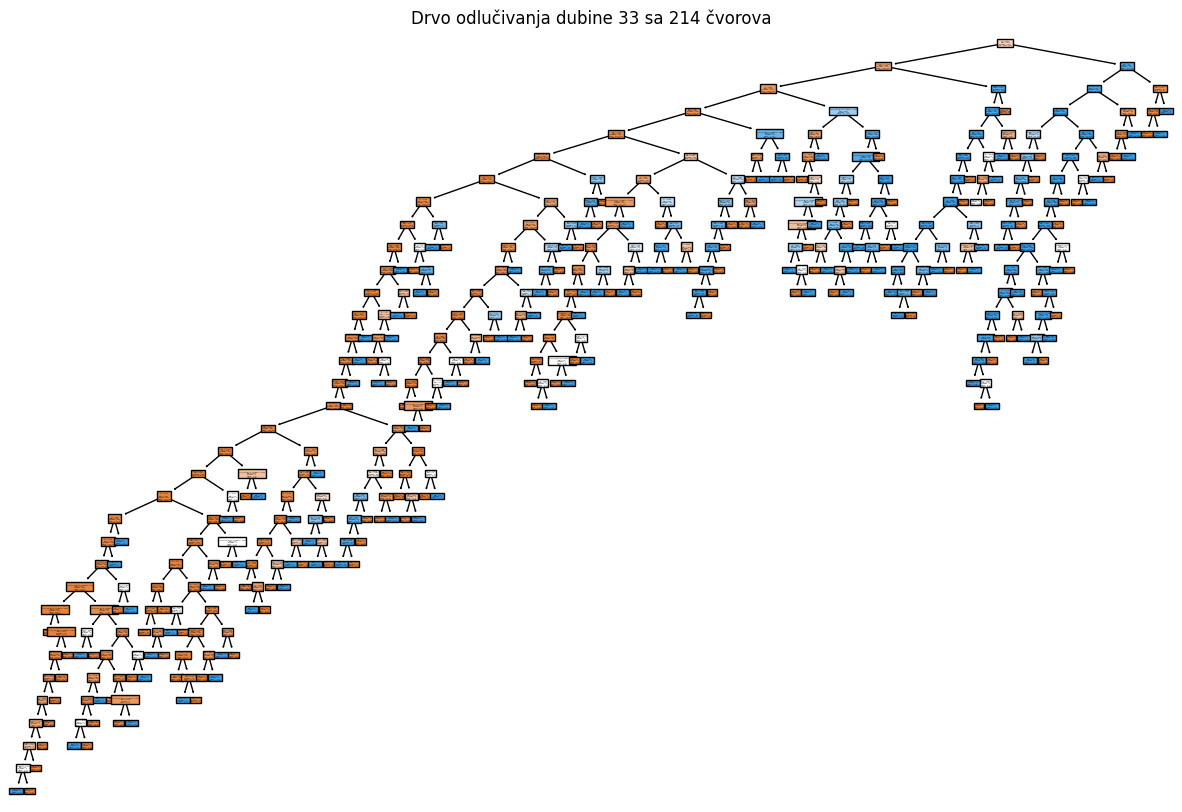

---------------------------------------------------------------------------------
Parametri modela DecisionTreeClassifier
ccp_alpha 0.0
class_weight None
criterion gini
max_depth None
max_features None
max_leaf_nodes None
min_impurity_decrease 0.0
min_samples_leaf 1
min_samples_split 2
min_weight_fraction_leaf 0.0
random_state None
splitter best
---------------------------------------------------------------------------------


In [22]:
plot_decision_tree(decision_tree_classifier, feature_names)

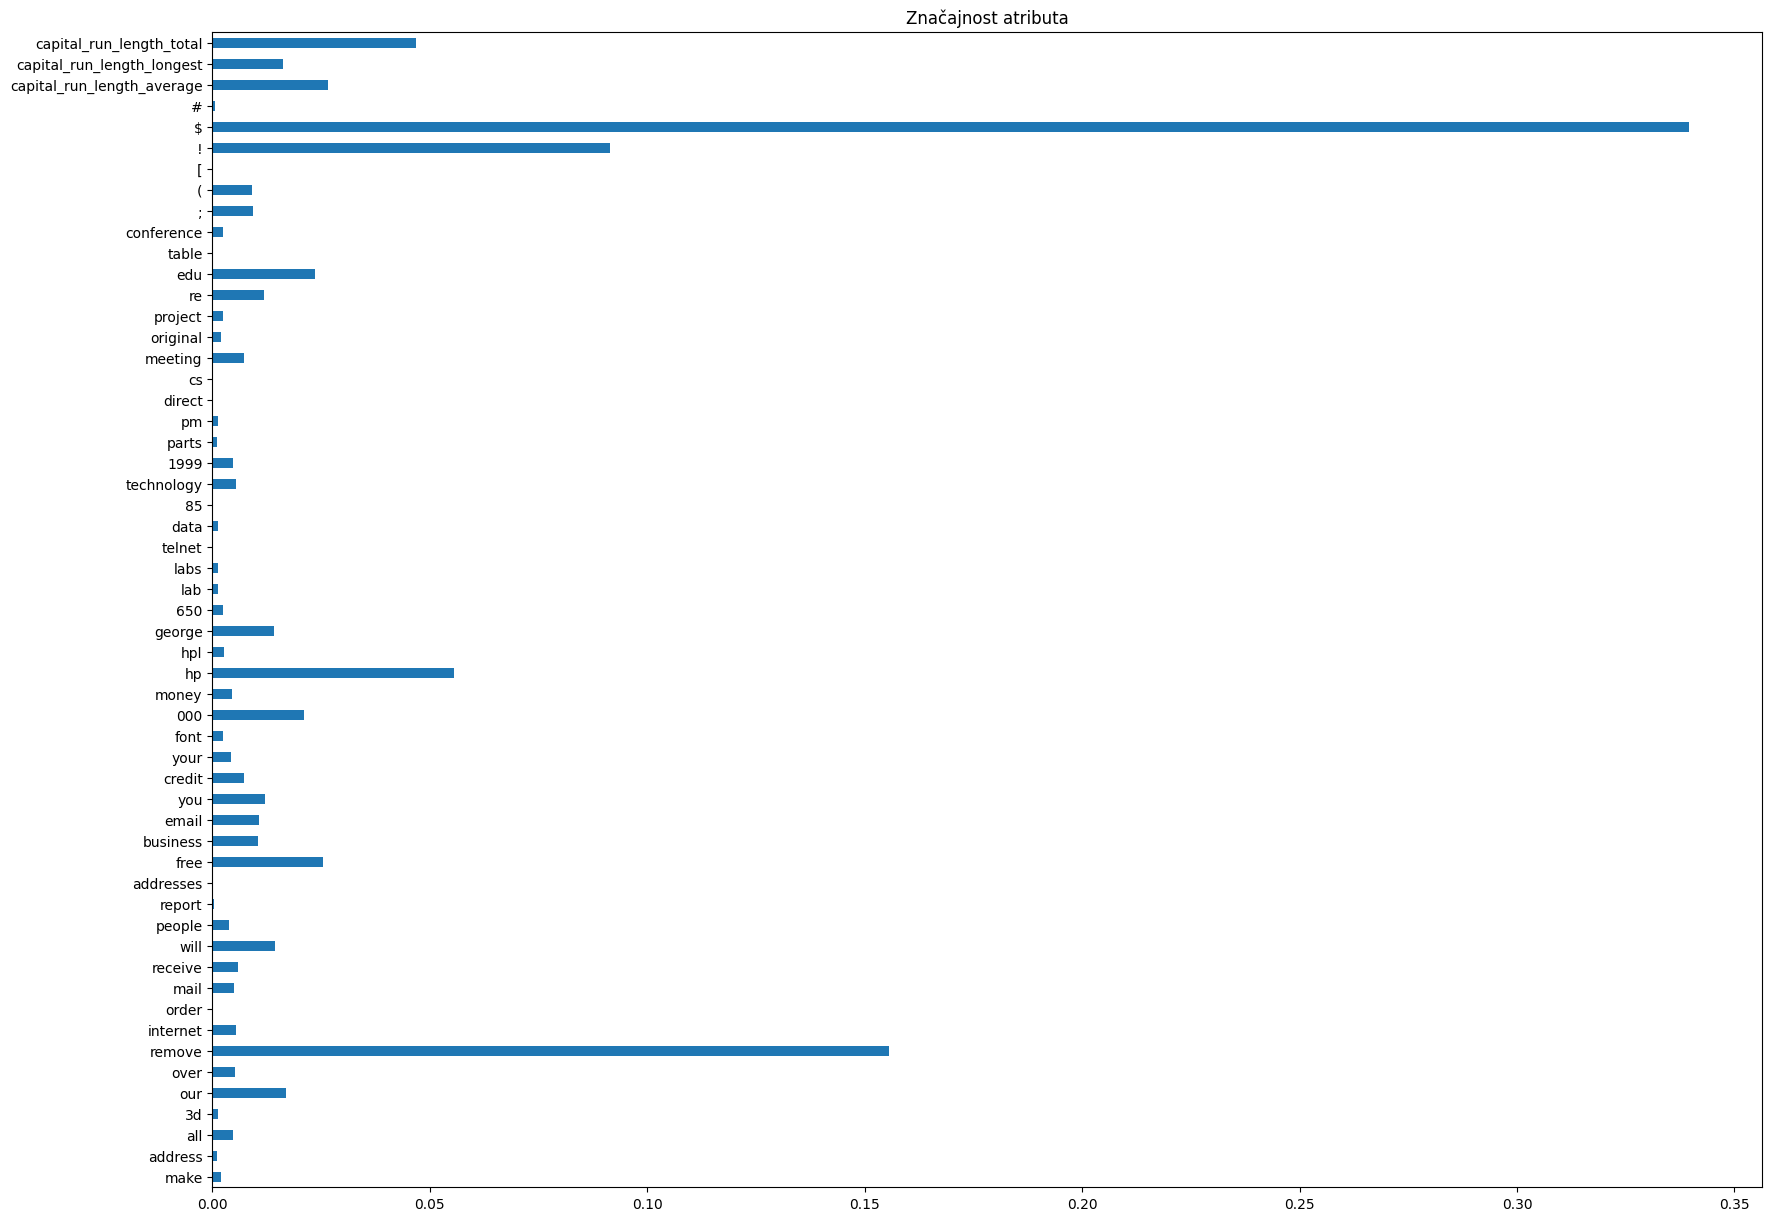

In [23]:
plt.figure(figsize= (20, 15))
pd.Series(decision_tree_classifier.feature_importances_, index=X.columns).plot.barh()
plt.title("Značajnost atributa")
plt.show()

> Primećujemo da nisu svi atributi bili podjednako iskorišćeni prilikom rada algoritma. 

#### Trening skup

In [24]:
report(decision_tree_classifier, X_train, y_train)

Klasifikacioni izveštaj za model DecisionTreeClassifier nad trening podacima
------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1951
           1       1.00      1.00      1.00      1269

    accuracy                           1.00      3220
   macro avg       1.00      1.00      1.00      3220
weighted avg       1.00      1.00      1.00      3220



> Prema ovim rezultatima možemo zaključiti da se model preprilagodio podacima iz trening skupa, što najčešće utiče na to da će na neviđenim podacima on imati slabu moć generalizacije.

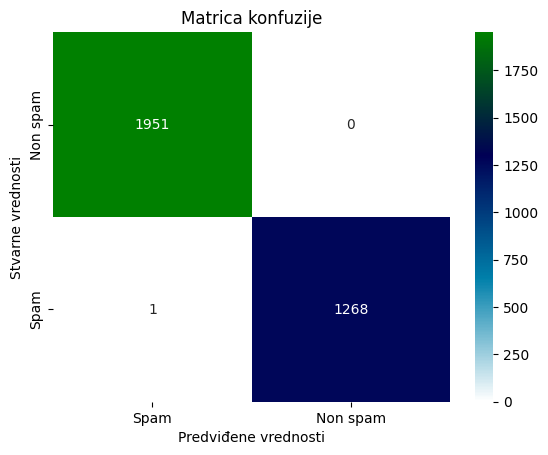

In [25]:
plot_confusion_matrix(decision_tree_classifier, X_train, y_train)

> Možemo primetiti da model radi skroz tačno nad trening podacima.

#### Test skup

In [26]:
report(decision_tree_classifier, X_test, y_test, text= 'test')

Klasifikacioni izveštaj za model DecisionTreeClassifier nad test podacima
------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.44      0.59       837
           1       0.52      0.94      0.67       544

    accuracy                           0.64      1381
   macro avg       0.72      0.69      0.63      1381
weighted avg       0.76      0.64      0.62      1381



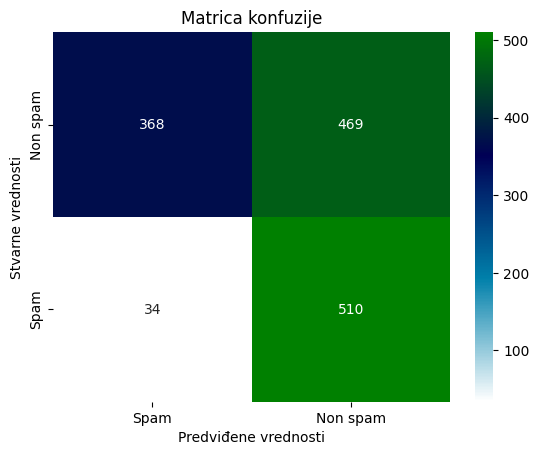

In [27]:
plot_confusion_matrix(decision_tree_classifier, X_test, y_test)

> Iako su rezultati na trening skupu bili idealni, vidimo da na test skupu model ne radi kako bismo mi želeli.

### Odabir najboljih parametara

In [28]:
params =  {
    'criterion': ['gini', 'entropy'],
    'max_depth': [x for x in range(3, 30)],
    'max_features': [x for x in range(3, 40)]
}

fst_estimator = GridSearchCV(DecisionTreeClassifier(class_weight= 'balanced'), param_grid= params)
snd_estimator = GridSearchCV(DecisionTreeClassifier(), param_grid= params)

> U ovom slučaju, pokušavamo da procenimo optimalne parametre na dva načina: uz balansiranje klasa i bez.

#### Drvo odlučivanja sa balansiranim klasama

In [29]:
fst_estimator.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29],
                         'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                          14, 15, 16, 17, 18, 19, 20, 21, 22,
                                          23, 24, 25, 26, 27, 28, 29, 30, 31,
                                          32, ...]})

In [30]:
fst_estimator.best_params_

{'criterion': 'entropy', 'max_depth': 23, 'max_features': 30}

In [31]:
fst_estimator.best_score_

0.922360248447205

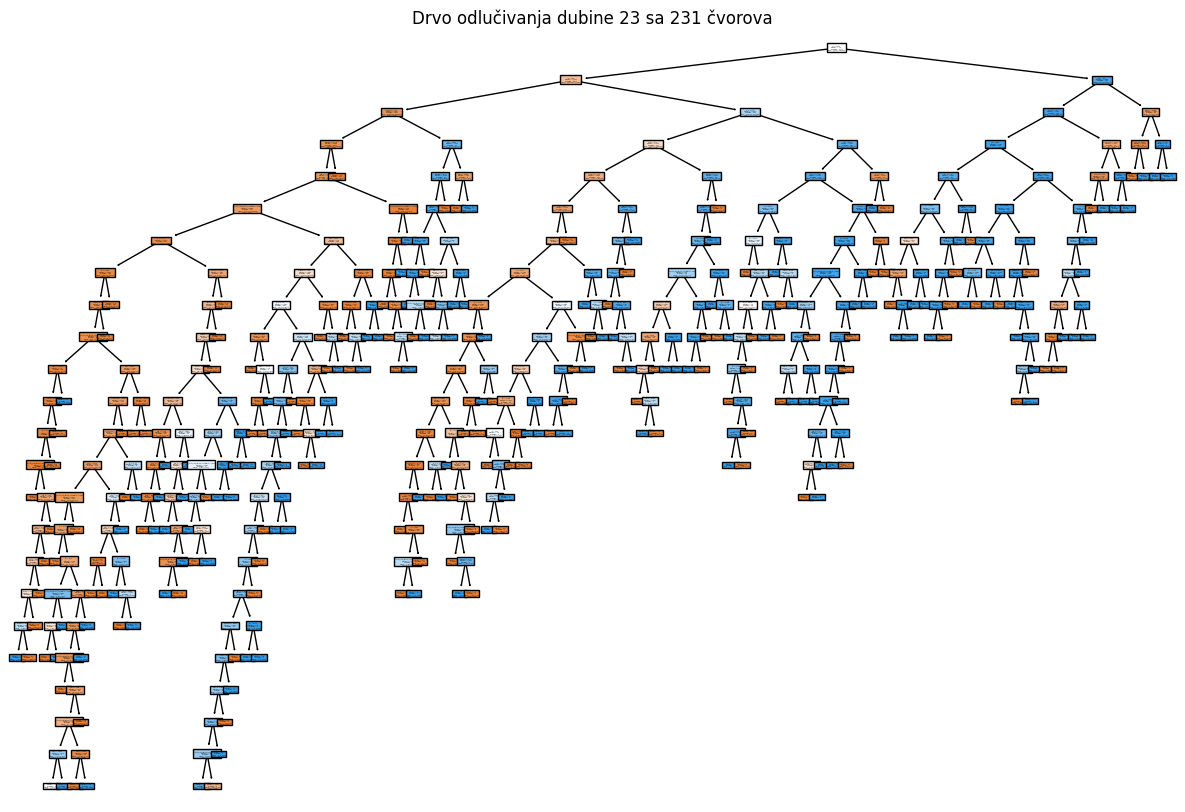

---------------------------------------------------------------------------------
Parametri modela DecisionTreeClassifier
ccp_alpha 0.0
class_weight balanced
criterion entropy
max_depth 23
max_features 30
max_leaf_nodes None
min_impurity_decrease 0.0
min_samples_leaf 1
min_samples_split 2
min_weight_fraction_leaf 0.0
random_state None
splitter best
---------------------------------------------------------------------------------


In [32]:
plot_decision_tree(fst_estimator.best_estimator_, feature_names)

In [33]:
report(fst_estimator.best_estimator_, X_train, y_train)

Klasifikacioni izveštaj za model DecisionTreeClassifier nad trening podacima
------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1951
           1       1.00      1.00      1.00      1269

    accuracy                           1.00      3220
   macro avg       1.00      1.00      1.00      3220
weighted avg       1.00      1.00      1.00      3220



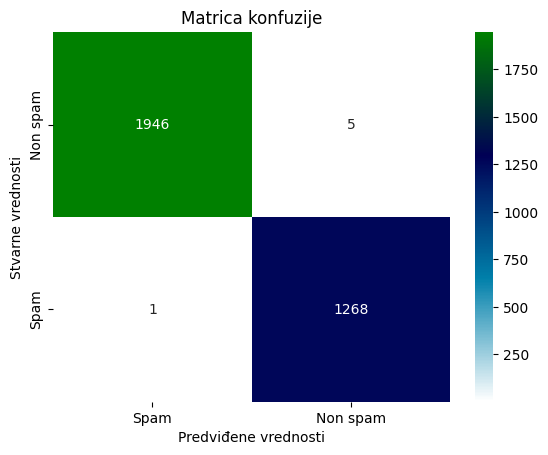

In [34]:
plot_confusion_matrix(fst_estimator.best_estimator_, X_train, y_train)

> Da li smo dobili poboljšanje nad test podacima?

In [35]:
report(fst_estimator.best_estimator_, X_test, y_test, 'test')

Klasifikacioni izveštaj za model DecisionTreeClassifier nad test podacima
------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       837
           1       0.67      0.93      0.78       544

    accuracy                           0.80      1381
   macro avg       0.81      0.82      0.79      1381
weighted avg       0.83      0.80      0.80      1381



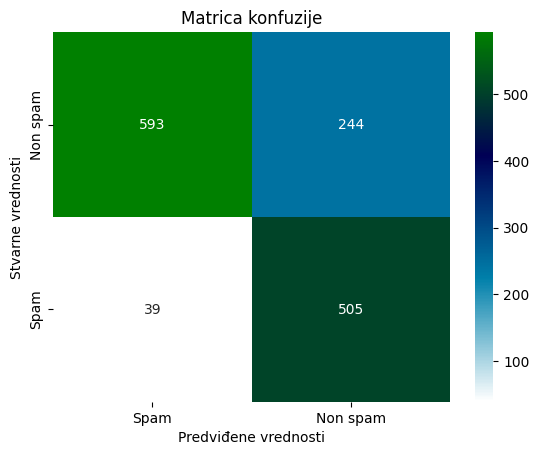

In [36]:
plot_confusion_matrix(fst_estimator.best_estimator_, X_test, y_test)

> Može se primetiti da je sada tačnost modela nad skupom za testiranje 0.88, što nam ukazuje da smo uspeli da popravimo model.

#### Drvo odlučivanja bez balansiranja klasa

In [37]:
snd_estimator.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29],
                         'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                          14, 15, 16, 17, 18, 19, 20, 21, 22,
                                          23, 24, 25, 26, 27, 28, 29, 30, 31,
                                          32, ...]})

In [38]:
snd_estimator.best_params_

{'criterion': 'gini', 'max_depth': 8, 'max_features': 33}

In [39]:
snd_estimator.best_score_

0.918944099378882

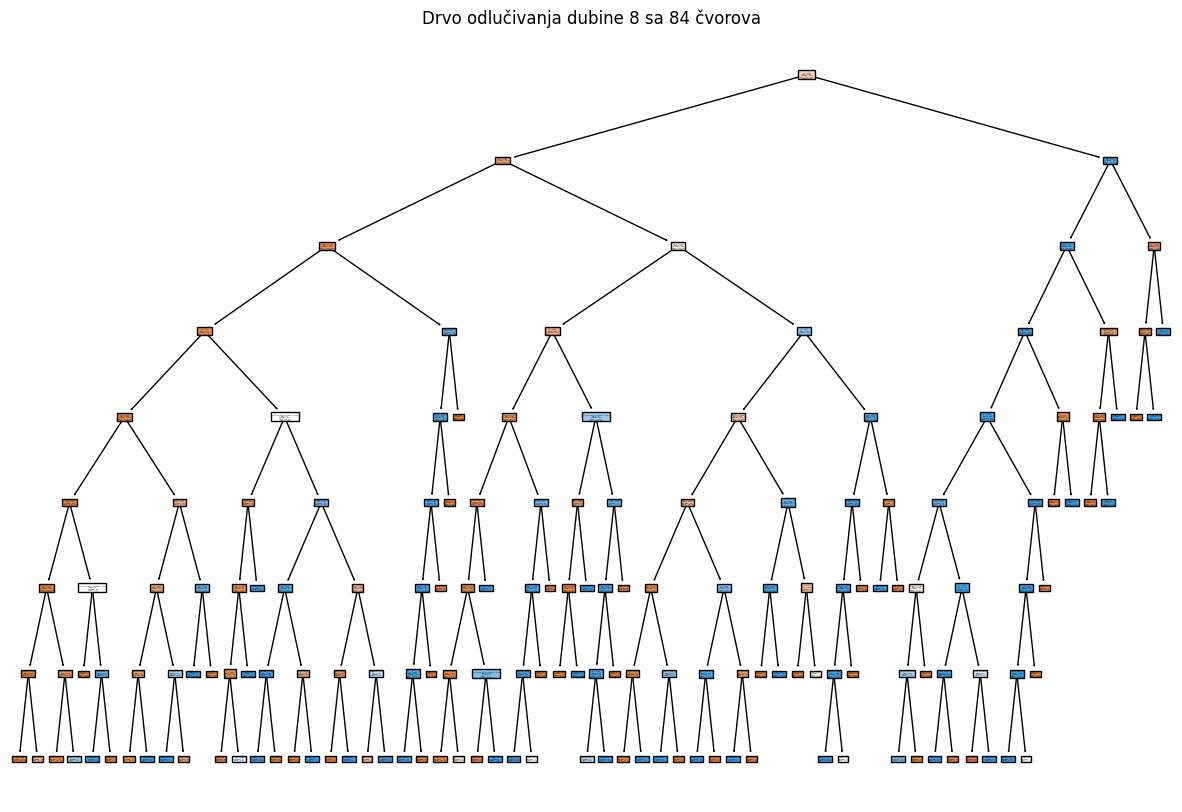

---------------------------------------------------------------------------------
Parametri modela DecisionTreeClassifier
ccp_alpha 0.0
class_weight None
criterion gini
max_depth 8
max_features 33
max_leaf_nodes None
min_impurity_decrease 0.0
min_samples_leaf 1
min_samples_split 2
min_weight_fraction_leaf 0.0
random_state None
splitter best
---------------------------------------------------------------------------------


In [40]:
plot_decision_tree(snd_estimator.best_estimator_, feature_names)

In [41]:
report(snd_estimator.best_estimator_, X_train, y_train)

Klasifikacioni izveštaj za model DecisionTreeClassifier nad trening podacima
------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1951
           1       0.97      0.92      0.95      1269

    accuracy                           0.96      3220
   macro avg       0.96      0.95      0.96      3220
weighted avg       0.96      0.96      0.96      3220



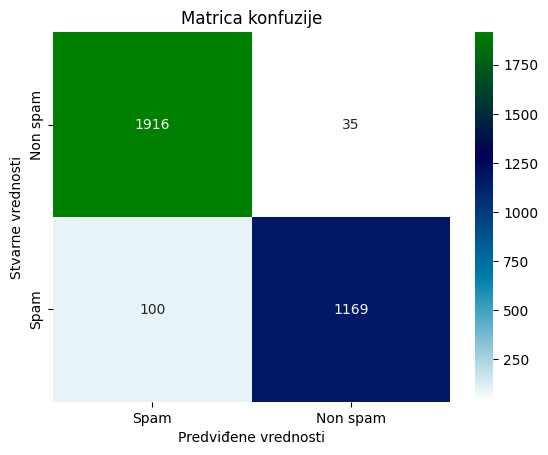

In [42]:
plot_confusion_matrix(snd_estimator.best_estimator_, X_train, y_train)

In [43]:
report(snd_estimator.best_estimator_, X_test, y_test, text= 'test')

Klasifikacioni izveštaj za model DecisionTreeClassifier nad test podacima
------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       837
           1       0.84      0.88      0.86       544

    accuracy                           0.89      1381
   macro avg       0.88      0.89      0.88      1381
weighted avg       0.89      0.89      0.89      1381



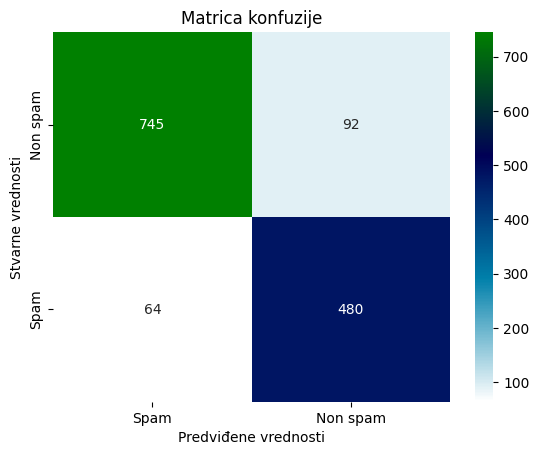

In [44]:
plot_confusion_matrix(snd_estimator.best_estimator_, X_test, y_test)

> Primećujemo da bez balansiranja klasa, ne uspevamo da poboljšamo rezultat modela na test skupu.